In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

In [ ]:
dataset_folder = os.path.join("/content/drive/MyDrive/Datasets/DL/plant-pathology-2020")

In [ ]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [ ]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))

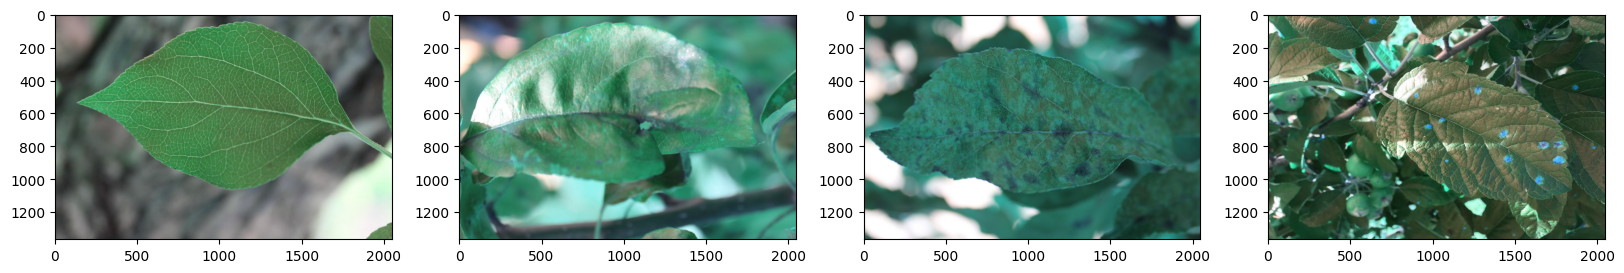

In [ ]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [ ]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [ ]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

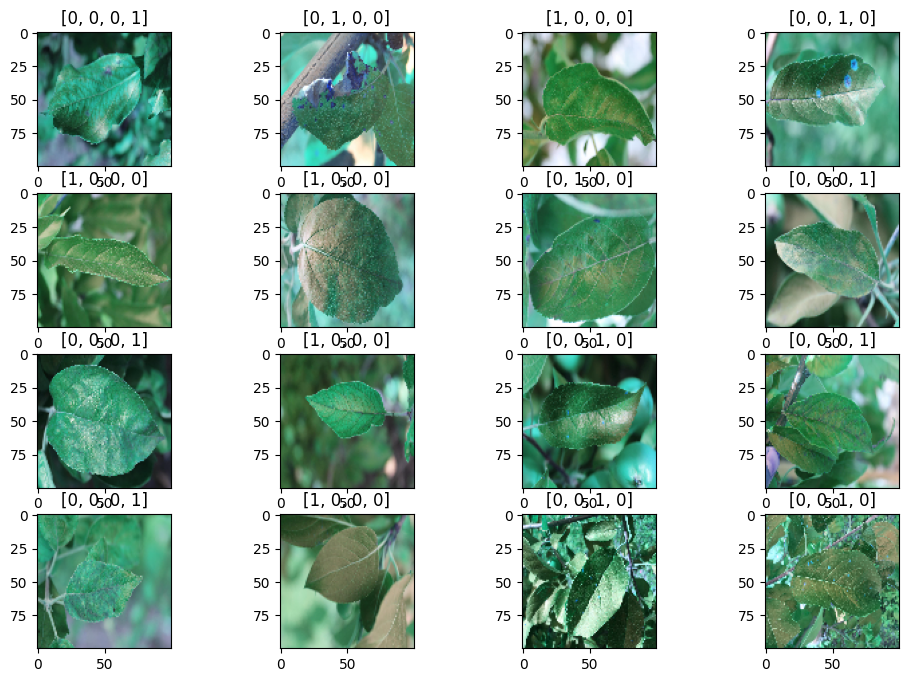

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [ ]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)

In [ ]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [ ]:
images.shape

(16389, 100, 100, 3)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


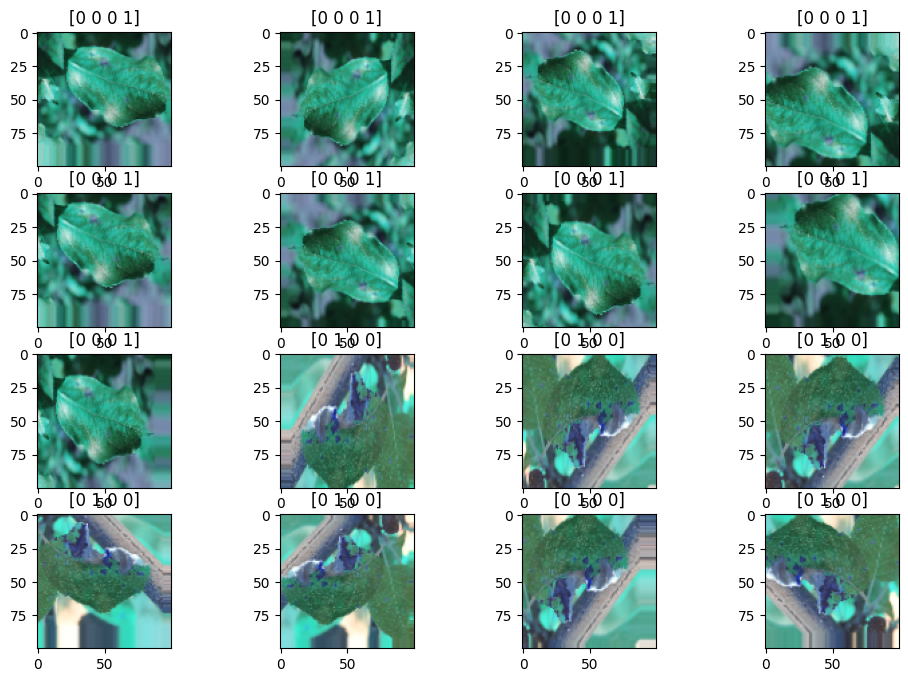

In [ ]:
plt.figure(figsize = (12, 8))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

In [ ]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001),
          loss = "categorical_crossentropy",
          metrics =["accuracy",
                     Precision(name='precision'),
                     Recall(name='recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 106, 106, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 50, 50, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 50, 50, 64)           256       ['conv1/conv[0][0]']      

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [ ]:
x_train.shape

(13930, 100, 100, 3)

In [ ]:
x_test.shape

(2459, 100, 100, 3)

In [ ]:
history = m.fit(x_train, y_train, epochs = 10, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

Epoch 1/10
436/436 [==============================] - 1929s 4s/step - loss: 0.6057 - accuracy: 0.7838 - precision: 0.8566 - recall: 0.7178 - lr: 0.0010
Epoch 2/10
436/436 [==============================] - 1821s 4s/step - loss: 0.3518 - accuracy: 0.8922 - precision: 0.9141 - recall: 0.8688 - lr: 0.0010
Epoch 3/10
436/436 [==============================] - 1800s 4s/step - loss: 0.2954 - accuracy: 0.9063 - precision: 0.9289 - recall: 0.8878 - lr: 0.0010
Epoch 4/10
436/436 [==============================] - 1809s 4s/step - loss: 0.2479 - accuracy: 0.9208 - precision: 0.9346 - recall: 0.9063 - lr: 0.0010
Epoch 5/10
436/436 [==============================] - 1802s 4s/step - loss: 0.2195 - accuracy: 0.9297 - precision: 0.9423 - recall: 0.9170 - lr: 0.0010
Epoch 6/10
436/436 [==============================] - 1803s 4s/step - loss: 0.1922 - accuracy: 0.9384 - precision: 0.9501 - recall: 0.9261 - lr: 0.0010
Epoch 7/10
436/436 [==============================] - 1788s 4s/step - loss: 0.1730 - acc

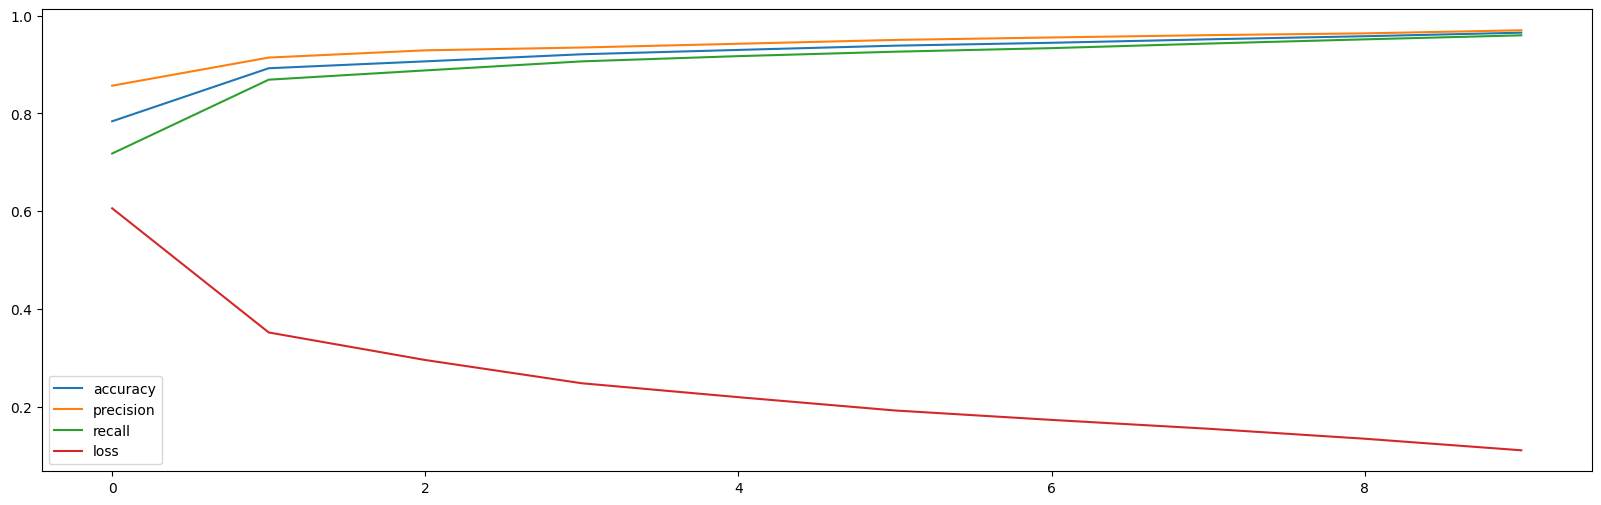

In [ ]:
plt.figure(figsize = (20, 6))
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [ ]:
m.evaluate(x_test, y_test, batch_size= 32)

77/77 [==============================] - 73s 882ms/step - loss: 0.9258 - accuracy: 0.7251 - precision: 0.7391 - recall: 0.7064


[0.925784707069397, 0.7250915169715881, 0.7391489148139954, 0.7063847184181213]